# Sentiment Analysis using NLP

Sentiment Analysis means to identify the view or emotion behind a situation. It basically means to analyze and find the 
emotion or intent behind a piece of text or speech or any mode of communication.

This burger has a very bad taste- negative review

I ordered this pizza today- neutral startement

I love this cheese sandwich, it's so delicious- positive review

In [10]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [12]:
df_train= pd.read_csv("train.txt", delimiter=";", names=['text','label'])

df_val= pd.read_csv("val.txt",delimiter=";", names=['text','label'])

In [13]:
df= pd.concat([df_train, df_val])
df.reset_index(inplace=True, drop=True)

In [14]:
print("Shape of the dataframe:",df.shape)
df.sample(5)

Shape of the dataframe: (18000, 2)


,text,label
1799,ive heard stories about julie baileys treatmen...,sadness
152,i still feel it does the genre a disservice wh...,joy
4449,i personally feel they are doomed to finish de...,sadness
8489,i am feeling something ive never ever felt bef...,joy
12837,i feel like its my fault for letting the vampi...,joy


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

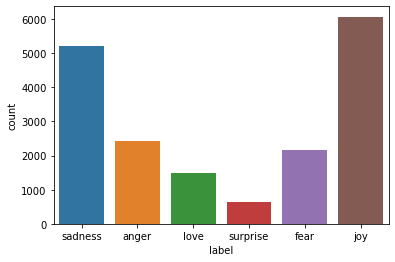

In [15]:
sns.countplot(df.label)

As we can see that, we have 6 labels or targets in the dataset. For the sake of simplicity, we will merge
these labels into two classes i.e. Positive and Negative sentiment

Positive Sentiment- joy, love, surprise

Negative Sentiment- anger, sadness, fear

In [16]:
def custom_encoder(df):
    df.replace(to_replace='surprise',value=1,inplace=True)
    df.replace(to_replace='love',value=1,inplace=True)
    df.replace(to_replace='joy',value=1,inplace=True)
    df.replace(to_replace='fear',value=0,inplace=True)
    df.replace(to_replace='anger',value=0,inplace=True)
    df.replace(to_replace='sadness',value=0,inplace=True)
    

In [17]:
custom_encoder(df['label'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

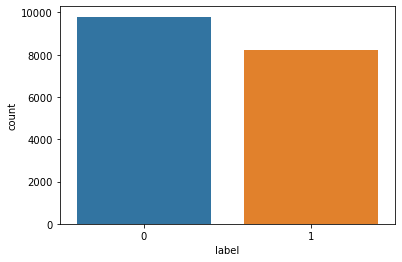

In [18]:
sns.countplot(df.label)

Now, we can see that our target has changed to 0 and 1 i.e 0 for Negative and 1 for Positive
and the data is more or less in a balanced state.

Data Preprocessing Steps

1. We will iterate through each record and using a regular expression we will get rid of any characters
apart from alphabets.

2. We will convert the string to lowercase becasue Python language is case-sensitive.

3. We will check for stopwords in the data and get rid of them.

4. We will perform stemming or lemmatization on each word.

In [24]:
lm=WordNetLemmatizer()

In [25]:
import re

def text_transformation(df_col):
    corpus=[]
    for item in df_col:
        new_item= re.sub('[^a-zA-Z]',' ',str(item))
        new_item= new_item.lower()
        new_item= new_item.split()
        new_item=[lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [26]:
corpus= text_transformation(df['text'])

In [27]:
cv= CountVectorizer(ngram_range=(1,2))
traindata=cv.fit_transform(corpus)
X=traindata
y=df.label

Now, comes the ML model part and we will use Random Forest classifier and we will tune hyperparameter using GridSearch CV

In [28]:
parameters= {'max_features':('auto','sqrt'),
             'n_estimators':[5,10],
             'max_depth':[10,None],
             'min_samples_split':[5],
             'min_samples_leaf':[1],
             'bootstrap':[True]
             }

Now, we will fit the data into grid search CV and view the best parameters using the best_params attribute

In [30]:
grid_search= GridSearchCV(RandomForestClassifier(), parameters, cv=5, return_train_score=True, n_jobs=1)
grid_search.fit(X,y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

In [32]:
for i in range(8):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'])

Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean Test Score:  0.5948333333333333
Rank:  [7 5 8 6 4 2 3 1]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean Test Score:  0.6216111111111111
Rank:  [7 5 8 6 4 2 3 1]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean Test Score:  0.5884444444444444
Rank:  [7 5 8 6 4 2 3 1]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean Test Score:  0.6172777777777778
Rank:  [7 5 8 6 4 2 3 1]
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean Test Score:  0.9093333333333333
Rank:  [7 5

Now, we will choose the best parameters obtained from GridSearchCV and create a final random forest classifier model
and then train our model.

In [33]:
rfc= RandomForestClassifier(max_features= grid_search.best_params_['max_features'],
                           max_depth= grid_search.best_params_['max_depth'],
                           n_estimators= grid_search.best_params_['n_estimators'],
                           min_samples_split= grid_search.best_params_['min_samples_split'],
                           min_samples_leaf= grid_search.best_params_['min_samples_leaf'],
                           bootstrap= grid_search.best_params_['bootstrap']
                           )

rfc.fit(X,y)

RandomForestClassifier(max_features='sqrt', min_samples_split=5,
                       n_estimators=10)

Test Data Transformation

Now we will finally read the test data and perform the same transformation we did on the training data
and finally evaluate the model on its prediction.

In [35]:
test_df= pd.read_csv('test.txt', delimiter=';', names=['text','label'])

In [36]:
X_test, y_test=test_df.text, test_df.label

# encode the labels into two classes 0 and 1
test_df= custom_encoder(y_test)

# pre-processing of text
test_corpus= text_transformation(X_test)

# convert text data into vectors
testdata= cv.transform(test_corpus)

# predict the target
predictions=rfc.predict(testdata)

Model Evaluation

We will evaluate our model using various merics such as accuracy score, precision score, recall score,
confusion matrix and create a ROC curve to visualise how our model performed.

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,roc_curve
from sklearn.metrics import classification_report, plot_confusion_matrix

acc_score= accuracy_score(y_test, predictions)
pre_score= precision_score(y_test, predictions)
rec_score=recall_score(y_test, predictions)

print('Accuracy_Score: ',acc_score)
print('Precision_Score: ',pre_score)
print('Recall_Score: ',rec_score)
print("-"*50)
cr=classification_report(y_test, predictions)
print(cr)

Accuracy_Score:  0.9515
Precision_Score:  0.9487459105779716
Recall_Score:  0.9456521739130435
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1080
           1       0.95      0.95      0.95       920

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



ROC Curve- We will find the probability of the class using the predict_proba() method of random forest classifier
and then we will plot the curve

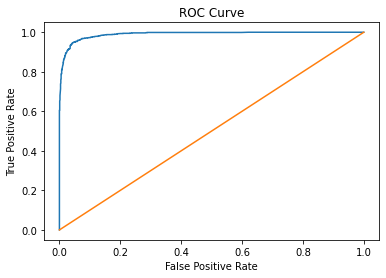

In [41]:
import matplotlib.pyplot as plt

predictions_probability= rfc.predict_proba(testdata)
fpr, tpr, threshold= roc_curve(y_test, predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Now we will check for custom input as well and let our model identify the sentiment of the input statement

In [42]:
def expression_check(prediction_input):
    if prediction_input==0:
        print("Input statement has negative sentiment")
    elif prediction_input==1:
        print("Input statement has positive sentiment")
    else:
        print("Invalid Statement")

Function to take the input statement and perform the same transformation we did earlier

In [46]:
def sentiment_predictor(input):
    input= text_transformation(input)
    transformed_input= cv.transform(input)
    prediction=rfc.predict(transformed_input)
    expression_check(prediction)

In [47]:
input1=["Sometimes I just don't want to go out"]
input2=["I bought a new phone and it's so good"]

In [48]:
sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has negative sentiment
Input statement has positive sentiment


# Movie Recommender System

Recommender Systems also labelled as recommendation systems, are statistical algorithms that recommend products to users
based on similarities between the buying trends of various user or similarities between the products.

In this project, you will see how to create a simple movie recommendation system, which recommends movies to a user using
item-based collaborative filtering.

Collaborative Filtering- The process used to calculate similarities between the buying tends of various user
or similarities between products is called as collaborative filtering.

Collaborative Filtering on the whole is classifier into two types- User based collaborative filtering,
item based collaborative filtering.

User Based Collaborative Filtering- It is dependent on user choices. For example, in a recommender system
based on user-based collaborative filtering, if two users X and Y, like products A and B and there is another
user Z who likes product A, then the product B will also be recommended to user Z.

One of the main disadvantages of User-based collaborative filtering is that user choices are evolved over time.

Hence, user-based collaborative filtering becomes a complex task statistically.

Item-based collaborative Filtering- In item based collaborative filtering, products are recommended based on
similarities between themselves. For example- if a user likes Product and product A has properties X and Y,
another product B with properties X and Y will also be recommended to the user.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The dataset contains around 100,000 movie reviews applied to 9,000 movies by 600 users

In [2]:
movie_ids_titles= pd.read_csv("movies.csv")

movie_ids_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movie_ids_ratings= pd.read_csv("ratings.csv")

movie_ids_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movie_ids_ratings.shape

(100836, 4)

Data Preprocessing- We need a dataframe that consists of userId, movieId, title and ratings. We can create such a dataframe
by merging movied_ids_title and movie_ids_ratings

In [5]:
movie_ids_ratings.drop(["timestamp"],inplace=True,axis=1)

movie_ids_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
movie_ids_titles.drop(["genres"],inplace=True,axis=1)

movie_ids_titles.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [7]:
merged_movie_df= pd.merge(movie_ids_ratings, movie_ids_titles, on='movieId')

merged_movie_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


Grouping dataset by title

In [8]:
merged_movie_df.groupby('title').describe()

userId                          \
                                           count        mean         std   
title                                                                      
'71 (2014)                                   1.0  610.000000         NaN   
'Hellboy': The Seeds of Creation (2004)      1.0  332.000000         NaN   
'Round Midnight (1986)                       2.0  354.500000   31.819805   
'Salem's Lot (2004)                          1.0  345.000000         NaN   
'Til There Was You (1997)                    2.0  229.000000  164.048773   
...                                          ...         ...         ...   
eXistenZ (1999)                             22.0  389.954545  167.161022   
xXx (2002)                                  24.0  272.916667  174.297576   
xXx: State of the Union (2005)               5.0  386.000000  148.801882   
¡Three Amigos! (1986)                       26.0  279.807692  193.794947   
À nous la liberté (Freedom for Us) (1931)    1.0  527.000000         NaN   

                                                                         \
                                             min     25%    50%     75%   
title                                                                     
'71 (2014)                                 610.0  610.00  610.0  610.00   
'Hellboy': The Seeds of Creation (2004)    332.0  332.00  332.0  332.00   
'Round Midnight (1986)                     332.0  343.25  354.5  365.75   
'Salem's Lot (2004)                        345.0  345.00  345.0  345.00   
'Til There Was You (1997)                  113.0  171.00  229.0  287.00   
...                                          ...     ...    ...     ...   
eXistenZ (1999)                             95.0  278.25  419.5  509.25   
xXx (2002)                                   9.0  131.25  240.5  418.50   
xXx: State of the Union (2005)             232.0  274.00  382.0  432.00   
¡Three Amigos! (1986)                        1.0  101.25  260.5  441.25   
À nous la liberté (Freedom for Us) (1931)  527.0  527.00  527.0  527.00   

                                                 movieId            ...  \
                                             max   count      mean  ...   
title                                                               ...   
'71 (2014)                                 610.0     1.0  117867.0  ...   
'Hellboy': The Seeds of Creation (2004)    332.0     1.0   97757.0  ...   
'Round Midnight (1986)                     377.0     2.0   26564.0  ...   
'Salem's Lot (2004)                        345.0     1.0   27751.0  ...   
'Til There Was You (1997)                  345.0     2.0     779.0  ...   
...                                          ...     ...       ...  ...   
eXistenZ (1999)                            608.0    22.0    2600.0  ...   
xXx (2002)                                 610.0    24.0    5507.0  ...   
xXx: State of the Union (2005)             610.0     5.0   33158.0  ...   
¡Three Amigos! (1986)                      599.0    26.0    2478.0  ...   
À nous la liberté (Freedom for Us) (1931)  527.0     1.0    5560.0  ...   

                                                              rating  \
                                                75%       max  count   
title                                                                  
'71 (2014)                                 117867.0  117867.0    1.0   
'Hellboy': The Seeds of Creation (2004)     97757.0   97757.0    1.0   
'Round Midnight (1986)                      26564.0   26564.0    2.0   
'Salem's Lot (2004)                         27751.0   27751.0    1.0   
'Til There Was You (1997)                     779.0     779.0    2.0   
...                                             ...       ...    ...   
eXistenZ (1999)                              2600.0    2600.0   22.0   
xXx (2002)                                   5507.0    5507.0   24.0   
xXx: State of the Union (2005)              33158.0   33158.0    5.0   
¡Three Amig

In [9]:
merged_movie_df.groupby('title')['rating'].mean().head()

title
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: rating, dtype: float64

Sort the movie title by the ascending order of the average user ratings

In [10]:
merged_movie_df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Gena the Crocodile (1969)              5.0
True Stories (1986)                    5.0
Cosmic Scrat-tastrophe (2015)          5.0
Love and Pigeons (1985)                5.0
Red Sorghum (Hong gao liang) (1987)    5.0
Name: rating, dtype: float64

Print the movies in the descending order of their ratings counts



In [11]:
merged_movie_df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

A movie which is rated by large number of peole is usually a good movie

Let's create a new dataframe that shows the title, mean rating and the rating counts.

In [12]:
movie_rating_mean_count= pd.DataFrame(columns=['rating_mean','rating_count'])

movie_rating_mean_count['rating_mean']= merged_movie_df.groupby('title')['rating'].mean()

movie_rating_mean_count['rating_count']=merged_movie_df.groupby('title')['rating'].count()

movie_rating_mean_count.head()

,rating_mean,rating_count
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


The above dataframe contains movie title, average ratings and the number of rating counts

We will plot a histogram to see how average ratings are distributed

<AxesSubplot:>

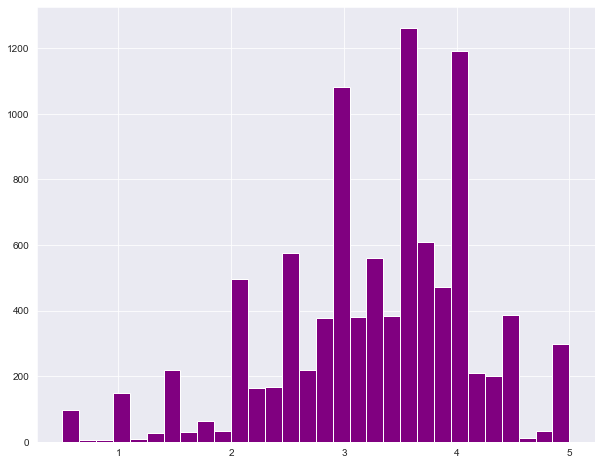

In [13]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")

movie_rating_mean_count['rating_mean'].hist(bins=30, color='purple')

In the above output most of the movies have an average rating between 3 and 4

Distribution for rating counts

<AxesSubplot:>

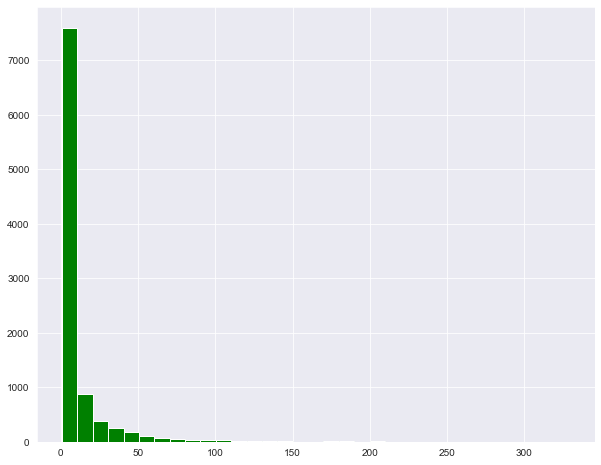

In [14]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")

movie_rating_mean_count["rating_count"].hist(bins=33, color="green")

In the above output, there are 7,000 movies with less than 10 rating counts. The number of movies decrease with an increase
in rating counts. Movies with more than 50 ratings are very few.

<AxesSubplot:xlabel='rating_mean', ylabel='rating_count'>

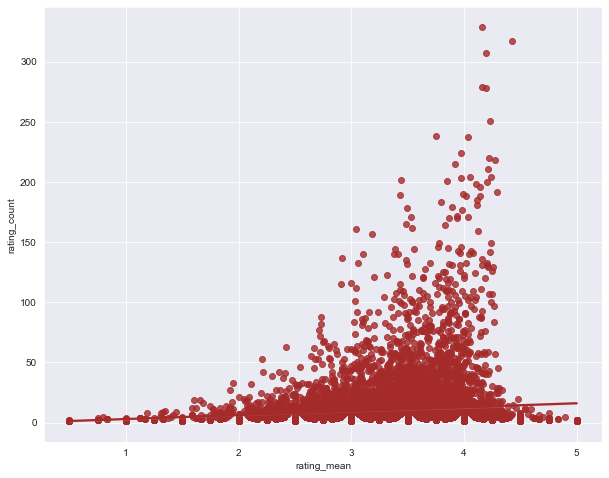

In [15]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.regplot(x="rating_mean",y="rating_count", data=movie_rating_mean_count, color="brown")

The movies with a higher number of rating counts tend to have higher mean ratings as well

# Item Based Collaborative Filtering

In item based collaborative filtering, products are recommended based on common characterisitcs.

In our dataset we have average ratings for different movies given by different users. We will use
the average ratings as the common characteristic of the collaborative filtering of movies.

The first step is to create a dataframe where each movie is represented by a column and rows contain user ratings for 
movies.

In [16]:
user_movie_rating_matrix= merged_movie_df.pivot_table(index='userId', columns="title", values="rating")

user_movie_rating_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [17]:
user_movie_rating_matrix.shape

(610, 9719)

In [18]:
import warnings
warnings.filterwarnings("ignore")

Now, we will find movie recommendation based on a single movie and then based on multiple movies

Finding recommendatin based on a single movie

Suppose that we want to find recommendation based on the movie Pulp Fiction (1994).

First, we will filter the column that contains the user ratings for the movie.

In [23]:
pulp_fiction_ratings= user_movie_rating_matrix["Pulp Fiction (1994)"]

Next, we will find the correlation between the user ratings of all movies and the user ratings for the movie pulp fiction

In [24]:
pulp_fiction_correlations= pd.DataFrame(user_movie_rating_matrix.corrwith(pulp_fiction_ratings),columns=["pf_corr"])

In [25]:
pulp_fiction_correlations.sort_values("pf_corr",ascending=False).head(5)

,pf_corr
title,
Rare Exports: A Christmas Tale (Rare Exports) (2010),1.0
Azumi (2003),1.0
"Maxed Out: Hard Times, Easy Credit and the Era of Predatory Lenders (2006)",1.0
"War Zone, The (1999)",1.0
"Wolfman, The (2010)",1.0


Correlation itself is not giving meaningful results.

One solution to this problem can be in addition to the correlation between the movies, we also use rating counts,
for the correlated movie as a criterion for fiinding the best recommendation.

In [26]:
pulp_fiction_correlations= pulp_fiction_correlations.join(movie_rating_mean_count["rating_count"])

pulp_fiction_correlations.head()

,pf_corr,rating_count
title,,
'71 (2014),NaN,1
'Hellboy': The Seeds of Creation (2004),NaN,1
'Round Midnight (1986),NaN,2
'Salem's Lot (2004),NaN,1
'Til There Was You (1997),NaN,2


We will remove all the movies with null correlation with the Pulp Fiction (1994)



In [28]:
pulp_fiction_correlations.dropna(inplace=True)

In [29]:
pulp_fiction_correlations.sort_values("pf_corr",ascending=False).head(5)

,pf_corr,rating_count
title,,
Rare Exports: A Christmas Tale (Rare Exports) (2010),1.0,2
Azumi (2003),1.0,2
"Maxed Out: Hard Times, Easy Credit and the Era of Predatory Lenders (2006)",1.0,2
"War Zone, The (1999)",1.0,2
"Wolfman, The (2010)",1.0,2


A better way is to find the movies iwth rating counts of atleast 50 and having the highest correlation with
Pulp Fiction (1994)

In [30]:
pulp_fiction_correlations_50=pulp_fiction_correlations[pulp_fiction_correlations['rating_count']>50]

pulp_fiction_correlations_50.sort_values('pf_corr',ascending=False).head()

,pf_corr,rating_count
title,,
Pulp Fiction (1994),1.000000,307
"Wolf of Wall Street, The (2013)",0.579915,54
Fight Club (1999),0.543465,218
Kill Bill: Vol. 1 (2003),0.504147,131
Interstellar (2014),0.503411,73


Finding Recommendatios based on multiple movies

In this we will see how to recommend movies to a user based on his ratings of multiple movies.

The first step is to create a data frame, which contains a correlation between all the movies in our dataset
in the form of a matrix.

In [31]:
all_movie_correlations= user_movie_rating_matrix.corr(method='pearson',min_periods=50)

The min_periods attribute value specifies the minimum number of observations required per pair of columns
to have a valid result.

A min_periods value of 50 specifies calculating correlation for only those pairs of movies that have been rated
by atleast 50 same users

In [32]:
all_movie_correlations.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now suppose that a user lons into website.

The user has already watched three movies and has given rating to those movies.

In [33]:
movie_data=[['Forrest Gump (1994)',4.0],['Fight Club (1999)',3.5],['Interstellar (2014)',4.0]]

test_movies= pd.DataFrame(movie_data, columns=['Movie_Name','Movie_Rating'])

test_movies.head()

,Movie_Name,Movie_Rating
0,Forrest Gump (1994),4.0
1,Fight Club (1999),3.5
2,Interstellar (2014),4.0


We will be recommending movies from the dataset based on the ratings by a new user for these three movies

In [34]:
print(test_movies['Movie_Name'][0])
print(test_movies['Movie_Rating'][0])

Forrest Gump (1994)
4.0


From the all_movie_correlations dataframe, let's obtian correlation values for the movies related to Forest Gump (1994)

In [37]:
all_movie_correlations['Forrest Gump (1994)'].dropna()

title
2001: A Space Odyssey (1968)                  0.191558
300 (2007)                                    0.321523
40-Year-Old Virgin, The (2005)                0.156517
Ace Ventura: Pet Detective (1994)             0.137870
Ace Ventura: When Nature Calls (1995)         0.421868
                                                ...   
Willy Wonka & the Chocolate Factory (1971)    0.195081
Wizard of Oz, The (1939)                      0.162368
X-Men (2000)                                  0.200786
X2: X-Men United (2003)                       0.246717
Young Frankenstein (1974)                     0.230049
Name: Forrest Gump (1994), Length: 313, dtype: float64

In [40]:
recommended_movies= pd.Series()

for i in range(0,2):
    movie= all_movie_correlations[test_movies['Movie_Name'][i]].dropna()
    movie= movie.map(lambda movie_corr: movie_corr*test_movies["Movie_Rating"][i])
    recommended_movies= recommended_movies.append(movie)

In [41]:
recommended_movies

2001: A Space Odyssey (1968)                  0.766231
300 (2007)                                    1.286094
40-Year-Old Virgin, The (2005)                0.626066
Ace Ventura: Pet Detective (1994)             0.551479
Ace Ventura: When Nature Calls (1995)         1.687472
                                                ...   
Who Framed Roger Rabbit? (1988)               0.874334
Willy Wonka & the Chocolate Factory (1971)    0.663971
Wizard of Oz, The (1939)                     -0.971160
X-Men (2000)                                 -0.063318
X2: X-Men United (2003)                      -0.661265
Length: 529, dtype: float64

To get a final recommendation, you can sort the movies in the descending order of the weighted correlation

In [42]:
recommended_movies.sort_values(inplace=True,ascending=False)

print(recommended_movies.head(10))

Forrest Gump (1994)                           4.000000
Fight Club (1999)                             3.500000
Mr. Holland's Opus (1995)                     2.608575
Lock, Stock & Two Smoking Barrels (1998)      2.570366
Django Unchained (2012)                       2.225161
Life Is Beautiful (La Vita è bella) (1997)    2.203741
Pocahontas (1995)                             2.200471
Big (1988)                                    1.969404
Good Will Hunting (1997)                      1.936169
Pulp Fiction (1994)                           1.902128
dtype: float64
